<a href="https://colab.research.google.com/github/chauhanneha16/Audio_Spoofing/blob/main/spoofing_transformer-CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d awsaf49/asvpoof-2019-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/asvpoof-2019-dataset
License(s): ODC Attribution License (ODC-By)
100% 23.6G/23.6G [03:06<00:00, 174MB/s]
100% 23.6G/23.6G [03:06<00:00, 135MB/s]


In [ ]:
%env KAGGLE_CONFIG_DIR=/root/.kaggle/

env: KAGGLE_CONFIG_DIR=/root/.kaggle/


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/asvpoof-2019-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import os
import numpy as np
import librosa
import tensorflow as tf


In [6]:
# Define paths and parameters
DATASET_PATH = "/content/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [7]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [9]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-78.88214 , -80.      , -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-71.71661 , -77.353325, -80.      , ...,   0.      ,
            0.      ,   0.      ],
         [-57.14656 , -59.50205 , -57.573334, ...,   0.      ,
            0.      ,   0.      ],
         ...,
         [-69.18776 , -63.819817, -67.85419 , ...,   0.      ,
            0.      ,   0.      ],
         [-70.22391 , -64.85324 , -68.70045 , ...,   0.      ,
            0.      ,   0.      ],
         [-72.25124 , -66.18086 , -68.856   , ...,   0.      ,
            0.      ,   0.      ]],
 
        [[-72.254776, -78.77455 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-69.887405, -76.79361 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-57.00554 , -52.203255, -48.832603, ..., -73.142075,
          -71.93824 , -75.95265 ],
         ...,
         [-80.      , -68.084435, -64.63213 , ..., -47.64021 ,
          -42.370796, -4

In [10]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [16]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [17]:
# Define test set from remaining data
X_test, y_test = X[split_index:], y_encoded[split_index:]


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

# Define Transformer model architecture
input_shape = (N_MELS, X_train.shape[2])  # Input shape for Transformer (time steps, features)
num_classes = NUM_CLASSES

# Input layer
inputs = Input(shape=input_shape)

# Positional encoding
position_embeddings = Embedding(input_shape[0], input_shape[1])(tf.range(input_shape[0]))
x = inputs + position_embeddings

# Transformer layers
num_heads = 8
ff_dim = 64
num_layers = 4
embedding_dim = 32

for _ in range(num_layers):
    # Multi-head self-attention
    x = LayerNormalization()(x)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = x + attention_output

  # Feed-forward layer
    x = LayerNormalization()(x)
    x_ff = Dense(units=ff_dim, activation='relu')(x)
    x_ff = Dropout(0.1)(x_ff)
    x_ff = Dense(units=109, activation='relu')(x_ff)
    x_ff = Dropout(0.1)(x_ff)
    x = x + x_ff

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 109)]           0         []                            
                                                                                                  
 tf.__operators__.add_9 (TF  (None, 128, 109)             0         ['input_2[0][0]']             
 OpLambda)                                                                                        
                                                                                                  
 layer_normalization_8 (Lay  (None, 128, 109)             218       ['tf.__operators__.add_9[0][0]
 erNormalization)                                                   ']                            
                                                                                            

Epoch 1/10
1425/1425 [==============================] - 41s 22ms/step - loss: 0.2237 - accuracy: 0.8928 - val_loss: 0.2000 - val_accuracy: 0.9008
Epoch 2/10
1425/1425 [==============================] - 30s 21ms/step - loss: 0.2029 - accuracy: 0.8976 - val_loss: 0.2017 - val_accuracy: 0.9026
Epoch 3/10
1425/1425 [==============================] - 30s 21ms/step - loss: 0.1961 - accuracy: 0.8975 - val_loss: 0.1925 - val_accuracy: 0.9046
Epoch 4/10
1425/1425 [==============================] - 30s 21ms/step - loss: 0.1840 - accuracy: 0.9046 - val_loss: 0.1804 - val_accuracy: 0.9087
Epoch 5/10
1425/1425 [==============================] - 30s 21ms/step - loss: 0.1747 - accuracy: 0.9111 - val_loss: 0.1871 - val_accuracy: 0.9108
Epoch 6/10
1425/1425 [==============================] - 30s 21ms/step - loss: 0.1694 - accuracy: 0.9148 - val_loss: 0.1741 - val_accuracy: 0.9131
Epoch 7/10
1425/1425 [==============================] - 29s 21ms/step - loss: 0.1644 - accuracy: 0.9176 - val_loss: 0.1759 -

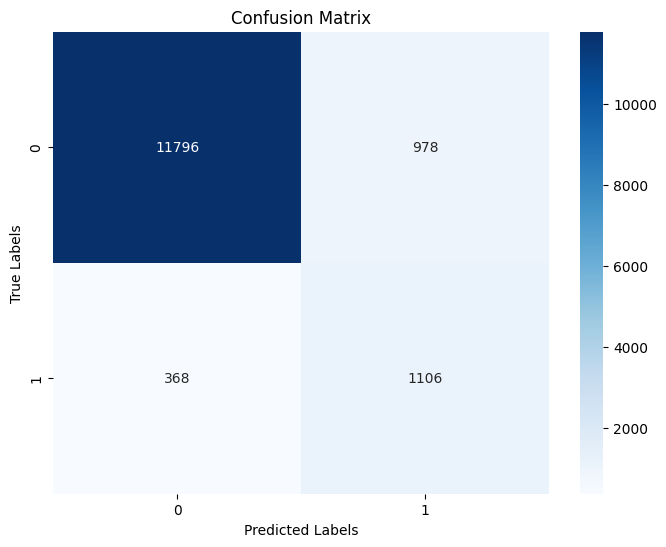

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
# Print the number of samples for training and testing
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# Force layer normalization to run on CPU
with tf.device('/CPU:0'):
    y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)



# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
